## import libraries

In [1]:
import glob
import calendar
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt

In [2]:
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [3]:
pd.options.display.max_colwidth = 100

## import data

In [4]:
df_all = pd.concat(map(pd.read_csv, glob.glob('raw_data/*.csv')))

In [5]:
#reset to account for all the data
df_all.reset_index(inplace=True)

In [6]:
df_all.columns

Index(['index', 'backers_count', 'blurb', 'category',
       'converted_pledged_amount', 'country', 'country_displayable_name',
       'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'],
      dtype='object')


Description of each column:

- backers_count - number of people who contributed funds to the project
- blurb - short description of the project
- category - contains the category and sub-category of the project
- converted_pledged_amount - amount of money pledged, converted to the currency in the 'current_currency' column
- country - country the project creator is from
- country_displayable_name - full name of country of project creator
- created_at - date and time of when the project was initially created on Kickstarter
- creator - name of the project creator and other information about them, e.g. Kickstarter id number
- currency - original currency the project goal was denominated in
- currency_symbol - symbol of the original currency the project goal was denominated in
- currency_trailing_code - code of the original currency the project goal was denominated in
- current_currency - currency the project goal was converted to
- deadline - date and time of when the project will close for donations
- disable_communication - whether or not a project owner disabled communication with their backers
- friends - unclear (null or empty)
- fx_rate - foreign exchange rate between the original currency and the current_currency
- goal - funding goal
- id - id number of the project
- is_backing - unclear (null or false)
- is_starrable - whether or not a project can be starred (liked and saved) by users
- is_starred - whether or not a project has been starred (liked and saved) by users
- launched_at - date and time of when the project was launched for funding
- location - contains the town or city of the project creator
- name - name of the project
- permissions - unclear (null or empty)
- photo - contains a link and information to the project's photo/s
- pledged - amount pledged in the current_currency
- profile - details about the project's profile, including id number and various visual settings
- slug - name of the project with hyphens instead of spaces
- source_url - url for the project's category
- spotlight - after a project has been successful, it is spotlighted on the Kickstarter website
- staff_pick - whether a project was highlighted as a staff_pick when it was launched/live
- state - whether a project was successful, failed, canceled, suspending or still live
- state_changed_at - date and time of when a project's status was changed (same as the deadline for successful and failed projects)
- static_usd_rate - conversion rate between the original currency and USD
- urls - url to the project's page
- usd_pledged - amount pledged in USD
- usd_type - domestic or international

In [7]:
df_all.head()

,index,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,0,4,Looking for donations and feedback on my ideas with wood working. Started out making side grain ...,"{""id"":356,""name"":""Woodworking"",""slug"":""crafts/woodworking"",""position"":14,""parent_id"":26,""parent_...",200,US,the United States,1449200332,"{""id"":240817199,""name"":""Tim"",""is_registered"":null,""is_email_verified"":null,""chosen_currency"":nul...",USD,...,wood-butcher-block-and-jewelry-boxes,https://www.kickstarter.com/discover/categories/crafts/woodworking,False,False,failed,1451839263,1.000000,"{""web"":{""project"":""https://www.kickstarter.com/projects/240817199/wood-butcher-block-and-jewelry...",200.000000,international
1,1,545,"Logan McBride was a magical girl with a destiny. Now, she's a 30-year-old New Yorker with rent t...","{""id"":252,""name"":""Graphic Novels"",""slug"":""comics/graphic novels"",""position"":4,""parent_id"":3,""par...",26773,US,the United States,1494092401,"{""id"":248241887,""name"":""Pat Shand"",""slug"":""patshand"",""is_registered"":null,""is_email_verified"":nu...",USD,...,destiny-ny-volume-two,https://www.kickstarter.com/discover/categories/comics/graphic%20novels,True,True,successful,1506643200,1.000000,"{""web"":{""project"":""https://www.kickstarter.com/projects/patshand/destiny-ny-volume-two?ref=disco...",26773.000000,international
2,2,267,Wonderful 3D Popup Christmas Cards. Opening this greeting card reveals a brilliantly crafted scu...,"{""id"":351,""name"":""Printing"",""slug"":""crafts/printing"",""position"":9,""parent_id"":26,""parent_name"":""...",10989,DE,Germany,1444289040,"{""id"":225932455,""name"":""nalacards"",""slug"":""nalacards"",""is_registered"":null,""is_email_verified"":n...",EUR,...,wonderful-3d-popup-christmas-cards-small-yet-meani,https://www.kickstarter.com/discover/categories/crafts,True,True,successful,1447016412,1.139062,"{""web"":{""project"":""https://www.kickstarter.com/projects/nalacards/wonderful-3d-popup-christmas-c...",11653.747824,international
3,3,96,Hi everyone. I love animals and I love to crochet. I want to combine the two to help my animal r...,"{""id"":344,""name"":""Crochet"",""slug"":""crafts/crochet"",""position"":2,""parent_id"":26,""parent_name"":""Cr...",1649,CA,Canada,1547488018,"{""id"":1240360759,""name"":""Tabetha Jollimore"",""is_registered"":null,""is_email_verified"":null,""chose...",CAD,...,animal-scarves-to-help-the-animals,https://www.kickstarter.com/discover/categories/crafts/crochet,True,False,successful,1550678590,0.754100,"{""web"":{""project"":""https://www.kickstarter.com/projects/1240360759/animal-scarves-to-help-the-an...",1641.894476,international
4,4,444,"Slim, Earth-friendly hangers with an innovative notch that eliminates the stretching of collars.","{""id"":28,""name"":""Product Design"",""slug"":""design/product design"",""position"":5,""parent_id"":7,""pare...",26752,US,the United States,1527556474,"{""id"":1106375862,""name"":""Ensu Design"",""is_registered"":null,""is_email_verified"":null,""chosen_curr...",USD,...,mozu-hanger,https://www.kickstarter.com/discover/categories/design,True,False,successful,1598108164,1.000000,"{""web"":{""project"":""https://www.kickstarter.com/projects/1106375862/mozu-hanger?ref=discovery_cat...",26752.000000,international


In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213583 entries, 0 to 213582
Data columns (total 39 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   index                     213583 non-null  int64  
 1   backers_count             213583 non-null  int64  
 2   blurb                     213576 non-null  object 
 3   category                  213583 non-null  object 
 4   converted_pledged_amount  213583 non-null  int64  
 5   country                   213583 non-null  object 
 6   country_displayable_name  213583 non-null  object 
 7   created_at                213583 non-null  int64  
 8   creator                   213583 non-null  object 
 9   currency                  213583 non-null  object 
 10  currency_symbol           213583 non-null  object 
 11  currency_trailing_code    213583 non-null  bool   
 12  current_currency          213583 non-null  object 
 13  deadline                  213583 non-null  i

In [9]:
df_all.shape

(213583, 39)

In [10]:
df_all[df_all['id']==1117024940]

,index,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
25831,279,0,Null,"{""id"":278,""name"":""People"",""slug"":""photography/people"",""position"":4,""parent_id"":15,""parent_name"":...",0,US,the United States,1404943871,"{""id"":764828689,""name"":""Art C."",""is_registered"":null,""is_email_verified"":null,""chosen_currency"":...",USD,...,girls-of-southeastern-saturday-swimsuit-calendar,https://www.kickstarter.com/discover/categories/photography/people,False,False,failed,1407992100,1.0,"{""web"":{""project"":""https://www.kickstarter.com/projects/764828689/girls-of-southeastern-saturday...",0.0,international


## data preprocessing

### for null and other inapplicable columns

In [11]:
# drop columns of platform interactions containing mostly nulls
df = df_all.drop(['friends', 'is_backing', 'is_starred', 'permissions'], axis=1, inplace=False)

In [12]:
# drop columns with data already included elsewhere in the dataset
df.drop(['converted_pledged_amount', 'country_displayable_name', 'pledged'], 
        axis=1, inplace=True)

In [13]:
# drop columns not included for use in this analysis
df.drop(['creator', 'location', 'photo', 'profile', 'slug', 'source_url', 'urls', 
         'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 
         'fx_rate', 'usd_type'], axis=1, inplace=True)

In [14]:
#drop columns which are tied to the target
df.drop(['spotlight', 'state_changed_at'], axis=1, inplace=True)

In [15]:
# Drop disable_communication - bools are all false
df.drop('disable_communication', axis=1, inplace=True)

### for duplicate rows

In [16]:
#see sum of duplicate rows by 'id'
df_all.duplicated(subset='id').sum()

25769

In [17]:
df = df.reset_index(drop=True) #reset index to easily search by integer-based location

In [18]:
#see duplicate rows by 'id'
df[df["id"].isin(df["id"][df["id"].duplicated()])]

,index,backers_count,blurb,category,country,created_at,deadline,goal,id,is_starrable,launched_at,name,staff_pick,state,static_usd_rate,usd_pledged
2,2,267,Wonderful 3D Popup Christmas Cards. Opening this greeting card reveals a brilliantly crafted scu...,"{""id"":351,""name"":""Printing"",""slug"":""crafts/printing"",""position"":9,""parent_id"":26,""parent_name"":""...",DE,1444289040,1447016400,2500.0,1484057434,False,1444957773,"Wonderful 3D Popup Christmas Cards: Small, Yet Meaningful",True,successful,1.139062,11653.747824
3,3,96,Hi everyone. I love animals and I love to crochet. I want to combine the two to help my animal r...,"{""id"":344,""name"":""Crochet"",""slug"":""crafts/crochet"",""position"":2,""parent_id"":26,""parent_name"":""Cr...",CA,1547488018,1550678590,100.0,1955625514,False,1548086590,Animal Scarves to Help the Animals!,False,successful,0.754100,1641.894476
4,4,444,"Slim, Earth-friendly hangers with an innovative notch that eliminates the stretching of collars.","{""id"":28,""name"":""Product Design"",""slug"":""design/product design"",""position"":5,""parent_id"":7,""pare...",US,1527556474,1598108164,7500.0,814342621,False,1594652164,Mozu Hanger - The Friendliest Hanger on the Planet,False,successful,1.000000,26752.000000
7,7,3,"Introducing the Primal Conceps ""LUCILLE"" product line based from the popular television show The...","{""id"":356,""name"":""Woodworking"",""slug"":""crafts/woodworking"",""position"":14,""parent_id"":26,""parent_...",US,1488839436,1492013616,100.0,1403250866,False,1489421616,Lucy Keychain bats,False,successful,1.000000,171.000000
9,9,32,The Seven Handmade Mechanical Models with Steampunk Style.,"{""id"":345,""name"":""DIY"",""slug"":""crafts/diy"",""position"":3,""parent_id"":26,""parent_name"":""Crafts"",""c...",HK,1525702846,1528990307,15000.0,615857771,False,1526398307,The Battle Warriors of Steam Punks,False,successful,0.127389,3286.861792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213577,3674,26,Bronwyn: The Further Adventures- Issue 1,"{""id"":250,""name"":""Comic Books"",""slug"":""comics/comic books"",""position"":2,""parent_id"":3,""parent_na...",AU,1594258211,1597548006,1000.0,1251772211,False,1594956006,Bronwyn- The Further Adventures- Issue 1,False,successful,0.699198,825.276829
213578,3675,27,I have received a scholarship to the famous Broadway Dance Center in New York City; But I need y...,"{""id"":255,""name"":""Residencies"",""slug"":""dance/residencies"",""position"":2,""parent_id"":6,""parent_nam...",GB,1467148276,1472240220,1000.0,434619322,False,1469453190,Help support me in NEW YORK!,False,successful,1.313831,1625.208737
213579,3676,206,MONSTERS✔️ ALIENS✔️ DEMONS✔️ KILLER CLOWNS✔️ TERRORIST✔️ AND A VIETNAM VETERAN TURNED ULTRA VIOL...,"{""id"":250,""name"":""Comic Books"",""slug"":""comics/comic books"",""position"":2,""parent_id"":3,""parent_na...",US,1609710908,1615006800,2000.0,1262668783,False,1612576876,DEAD END #1,False,successful,1.000000,9816.000000
213580,3677,31,Anna Reyes is a 2015 Resident Dance Artist for the Boston Center for the Arts. Her residency wil...,"{""id"":255,""name"":""Residencies"",""slug"":""dance/residencies"",""position"":2,""parent_id"":6,""parent_nam...",US,1425940072,1435377540,2500.0,2037776650,False,1432778563,The Good Parts of Being Alive - Boston Center for the Arts,True,successful,1.000000,2636.000000


In [19]:
#see a first example of duplicates
df[df['id'] == 1484057434]

,index,backers_count,blurb,category,country,created_at,deadline,goal,id,is_starrable,launched_at,name,staff_pick,state,static_usd_rate,usd_pledged
2,2,267,Wonderful 3D Popup Christmas Cards. Opening this greeting card reveals a brilliantly crafted scu...,"{""id"":351,""name"":""Printing"",""slug"":""crafts/printing"",""position"":9,""parent_id"":26,""parent_name"":""...",DE,1444289040,1447016400,2500.0,1484057434,False,1444957773,"Wonderful 3D Popup Christmas Cards: Small, Yet Meaningful",True,successful,1.139062,11653.747824
178448,1705,267,Wonderful 3D Popup Christmas Cards. Opening this greeting card reveals a brilliantly crafted scu...,"{""id"":351,""name"":""Printing"",""slug"":""crafts/printing"",""position"":9,""parent_id"":26,""parent_name"":""...",DE,1444289040,1447016400,2500.0,1484057434,False,1444957773,"Wonderful 3D Popup Christmas Cards: Small, Yet Meaningful",True,successful,1.139062,11653.747824


In [20]:
#confirm identical columns
df.iloc[2] == df.iloc[178448]

index              False
backers_count       True
blurb               True
category            True
country             True
created_at          True
deadline            True
goal                True
id                  True
is_starrable        True
launched_at         True
name                True
staff_pick          True
state               True
static_usd_rate     True
usd_pledged         True
dtype: bool

In [21]:
#drop duplicate rows by 'id'
df.drop_duplicates(subset='id', keep='first', inplace=True, ignore_index=True)

### extracting categories and subcategories

In [24]:
# Example category value
df.iloc[0]['category']

'{"id":356,"name":"Woodworking","slug":"crafts/woodworking","position":14,"parent_id":26,"parent_name":"Crafts","color":16744876,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/crafts/woodworking"}}}'

In [25]:
# Extracting the relevant sub-category section from the string
f = lambda x: x['category'].split('/')[1].split('","position')[0]
df['sub_category'] = df.apply(f, axis=1)

# Extracting the relevant category section from the string, and replacing the original category variable
f = lambda x: x['category'].split('"slug":"')[1].split('/')[0]
df['category'] = df.apply(f, axis=1)
f = lambda x: x['category'].split('","position"')[0] # Some categories do not have a sub-category, so do not have a '/' to split with
df['category'] = df.apply(f, axis=1)

### for datetime columns

In [26]:
# Converting dates from unix to datetime
date_cols = ['created_at', 'deadline', 'launched_at']
for col in date_cols:
    df[[col]] = pd.to_datetime(df[col], origin='unix', unit='s')

In [27]:
print(f"""The dataset contains projects added to Kickstarter between {min(df.created_at).strftime('%B %d %Y')} and {max(df.created_at).strftime('%B %d %Y')}.""")

The dataset contains projects added to Kickstarter between April 22 2009 and March 18 2021.


In [28]:
# Time between creating and launching a project
df['creation_to_launch_days'] = df['launched_at'] - df['created_at']
df['creation_to_launch_days'] = df['creation_to_launch_days'].dt.round('d').dt.days

# Campaign length
df['campaign_days'] = df['deadline'] - df['launched_at']
df['campaign_days'] = df['campaign_days'].dt.round('d').dt.days 

# Launch day of week
df['launch_day'] = df['launched_at'].dt.day_name()

# Deadline day of week
df['deadline_day'] = df['deadline'].dt.day_name()

### setting the index

In [29]:
# Setting the id column as the index
df.set_index('id', inplace=True)

### nlp on blurb

In [30]:
# special_characters removal
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas

def normalize_and_lemmatize(input):
    sample = remove_special_characters(input)
    words = nltk.word_tokenize(sample)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

In [31]:
stopword_list= stopwords.words('english')

In [32]:
# Dropping 7 rows where blurb is a null value
df = df.dropna(axis=0, subset=['blurb'])

In [33]:
df['clean_text'] = df['blurb'].map(lambda text: normalize_and_lemmatize(text))

In [34]:
# Replace empty strings with NaN values
df['clean_text'].replace('', np.nan, inplace=True)

In [35]:
# Dropping limited number of rows where clean text is made null due to preprocessing for nlp featurization
# (other languages, non-substantive blurbs, etc.)
df.dropna(subset=['clean_text'], inplace=True)

In [36]:
# Dropping unprocessed 'blurb' column
df.drop(['blurb'], axis=1, inplace=True)

### calculating additional features

In [37]:
# Mean pledge per backer
df['pledge_per_backer'] = round(df['usd_pledged']/df['backers_count'],2)

In [38]:
# Calculate new column 'usd_goal' as goal * static_usd_rate
df['usd_goal'] = round(df['goal'] * df['static_usd_rate'],2)

In [39]:
# Dropping goal, static_usd_rate
df.drop(['goal', 'static_usd_rate'], axis=1, inplace=True)

### target

In [40]:
df = df[df['state'].isin(['successful', 'failed'])]

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175493 entries, 2139821925 to 932512482
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   index                    175493 non-null  int64         
 1   backers_count            175493 non-null  int64         
 2   category                 175493 non-null  object        
 3   country                  175493 non-null  object        
 4   created_at               175493 non-null  datetime64[ns]
 5   deadline                 175493 non-null  datetime64[ns]
 6   is_starrable             175493 non-null  bool          
 7   launched_at              175493 non-null  datetime64[ns]
 8   name                     175493 non-null  object        
 9   staff_pick               175493 non-null  bool          
 10  state                    175493 non-null  object        
 11  usd_pledged              175493 non-null  float64       
 12  sub_

In [42]:
df[(df['usd_pledged'] == 0) & (df['backers_count'] == 0)]
#null values for pledge_per_backer result from zero backers_count and usd_pledged

,index,backers_count,category,country,created_at,deadline,is_starrable,launched_at,name,staff_pick,state,usd_pledged,sub_category,creation_to_launch_days,campaign_days,launch_day,deadline_day,clean_text,pledge_per_backer,usd_goal
id,,,,,,,,,,,,,,,,,,,,
1838728035,31,0,crafts,US,2015-06-05 17:18:39,2015-07-08 18:53:05,False,2015-06-08 18:53:05,Project GYM Clothes,False,failed,0.0,diy,3,30,Monday,Wednesday,mess boss new clothe line,NaN,2000.0
674736916,48,0,crafts,US,2014-08-11 00:14:15,2014-09-11 21:16:05,False,2014-08-12 21:16:05,ARTSY DAZZLE,False,failed,0.0,stationery,2,30,Tuesday,Thursday,dazzle tyme,NaN,3000.0
887538382,50,0,crafts,US,2015-10-16 14:19:01,2015-11-16 14:37:28,False,2015-10-17 13:37:28,Bushwick Soap Co.,False,failed,0.0,diy,1,30,Saturday,Monday,fun creative fragrences make love care brooklyn ny,NaN,2000.0
860729784,68,0,crafts,US,2015-08-11 14:19:05,2015-09-30 14:34:49,False,2015-08-31 14:34:49,Libby Lou Creates Greeting Cards,False,failed,0.0,stationery,20,30,Monday,Wednesday,handmade greet card make suit special occasion craft variety ways,NaN,1500.0
548148199,165,0,design,US,2015-01-24 00:43:00,2015-03-26 00:51:00,False,2015-02-01 21:03:30,Taking money's influence out of elective process.,False,failed,0.0,civic design,9,52,Sunday,Thursday,use instrument corruption restore responsible representative body govern,NaN,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585848398,3520,0,dance,US,2015-04-20 01:02:31,2015-06-19 20:23:33,False,2015-04-20 20:23:33,Elite Athletics All Star Cheerleading,False,failed,0.0,performances,1,60,Monday,Friday,star cheerlead gym build team compete national level,NaN,30000.0
1364701523,3551,0,crafts,US,2015-07-15 04:32:33,2015-08-19 16:53:43,False,2015-07-20 16:53:43,Johnson 115 Fiber Glass Restoration Project,False,failed,0.0,diy,6,30,Monday,Wednesday,look build community boat grass valley area anything contribute welcome ie resin fiber glass woo...,NaN,1000.0
2048243616,3613,0,crafts,US,2015-03-10 12:40:46,2015-05-10 16:45:36,False,2015-03-11 16:45:36,Video Documentary: Father and Son Car Build!,False,failed,0.0,diy,1,60,Wednesday,Sunday,father son dream build car together hilarious documentary lifetime opportunity bondbattle hood,NaN,24000.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175493 entries, 2139821925 to 932512482
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   index                    175493 non-null  int64         
 1   backers_count            175493 non-null  int64         
 2   category                 175493 non-null  object        
 3   country                  175493 non-null  object        
 4   created_at               175493 non-null  datetime64[ns]
 5   deadline                 175493 non-null  datetime64[ns]
 6   is_starrable             175493 non-null  bool          
 7   launched_at              175493 non-null  datetime64[ns]
 8   name                     175493 non-null  object        
 9   staff_pick               175493 non-null  bool          
 10  state                    175493 non-null  object        
 11  usd_pledged              175493 non-null  float64       
 12  sub_

## EDA

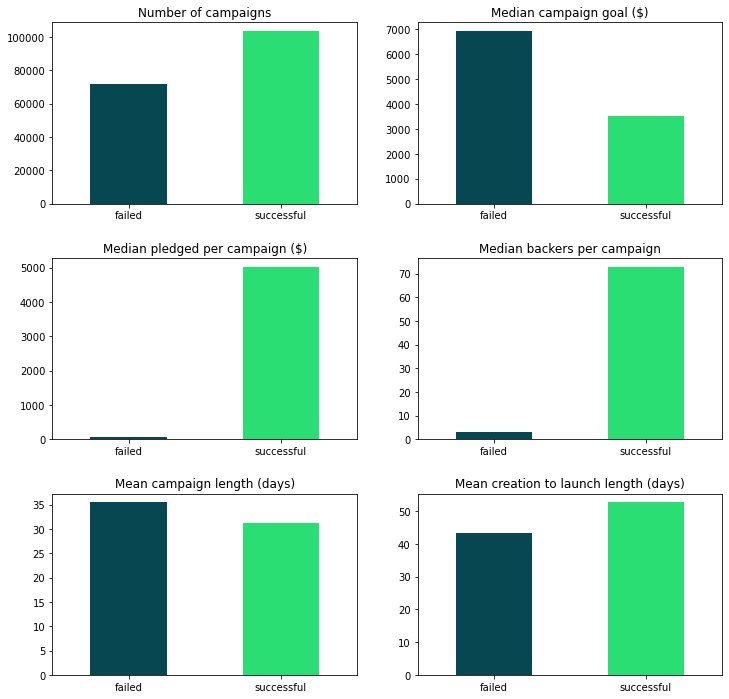

In [44]:
# Plotting the average amount pledged to successful and unsuccesful projects
fig, ((ax1, ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))

df['state'].value_counts(ascending=True).plot(kind='bar', ax=ax1, color=['#074751', '#2bde73'], rot=0)
ax1.set_title('Number of campaigns')
ax1.set_xlabel('')

df.groupby('state').usd_goal.median().plot(kind='bar', ax=ax2, color=['#074751', '#2bde73'], rot=0)
ax2.set_title('Median campaign goal ($)')
ax2.set_xlabel('')

df.groupby('state').usd_pledged.median().plot(kind='bar', ax=ax3, color=['#074751', '#2bde73'], rot=0)
ax3.set_title('Median pledged per campaign ($)')
ax3.set_xlabel('')

df.groupby('state').backers_count.median().plot(kind='bar', ax=ax4, color=['#074751', '#2bde73'], rot=0)
ax4.set_title('Median backers per campaign')
ax4.set_xlabel('')

df.groupby('state').campaign_days.mean().plot(kind='bar', ax=ax5, color=['#074751', '#2bde73'], rot=0)
ax5.set_title('Mean campaign length (days)')
ax5.set_xlabel('')

df.groupby('state').creation_to_launch_days.mean().plot(kind='bar', ax=ax6, color=['#074751', '#2bde73'], rot=0)
ax6.set_title('Mean creation to launch length (days)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

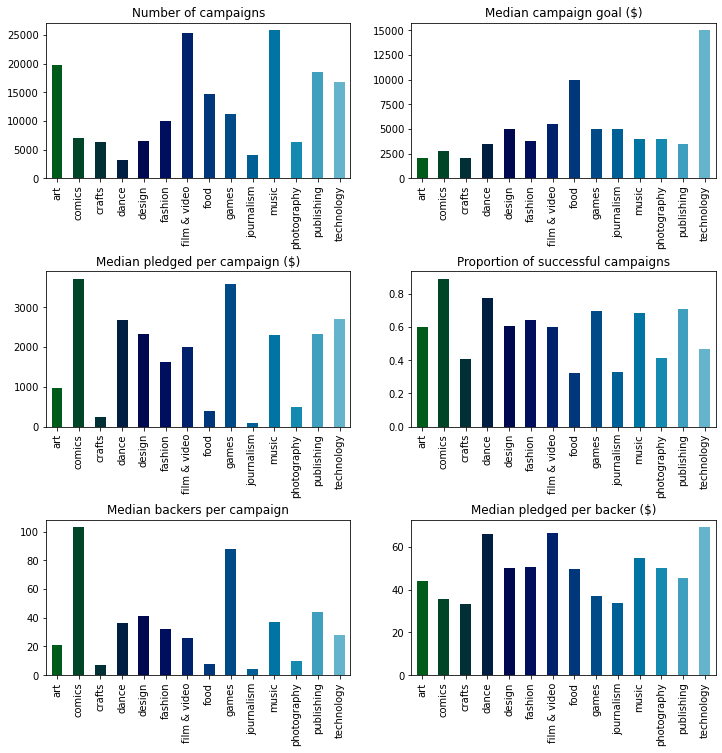

In [45]:
# Creating a dataframe grouped by category with columns for failed and successful
cat_df = pd.get_dummies(df.set_index('category').state).groupby('category').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))

color = cm.ocean(np.linspace(0.1,0.8,df.category.nunique())) # Setting a colormap

df.groupby('category').category.count().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Number of campaigns')
ax1.set_xlabel('')

df.groupby('category').usd_goal.median().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Median campaign goal ($)')
ax2.set_xlabel('')

df.groupby('category').usd_pledged.median().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Median pledged per campaign ($)')
ax3.set_xlabel('')

cat_df.div(cat_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax4, color=color) # Normalizes counts across rows
ax4.set_title('Proportion of successful campaigns')
ax4.set_xlabel('')

df.groupby('category').backers_count.median().plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Median backers per campaign')
ax5.set_xlabel('')

df.groupby('category').pledge_per_backer.median().plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.6)
plt.show()

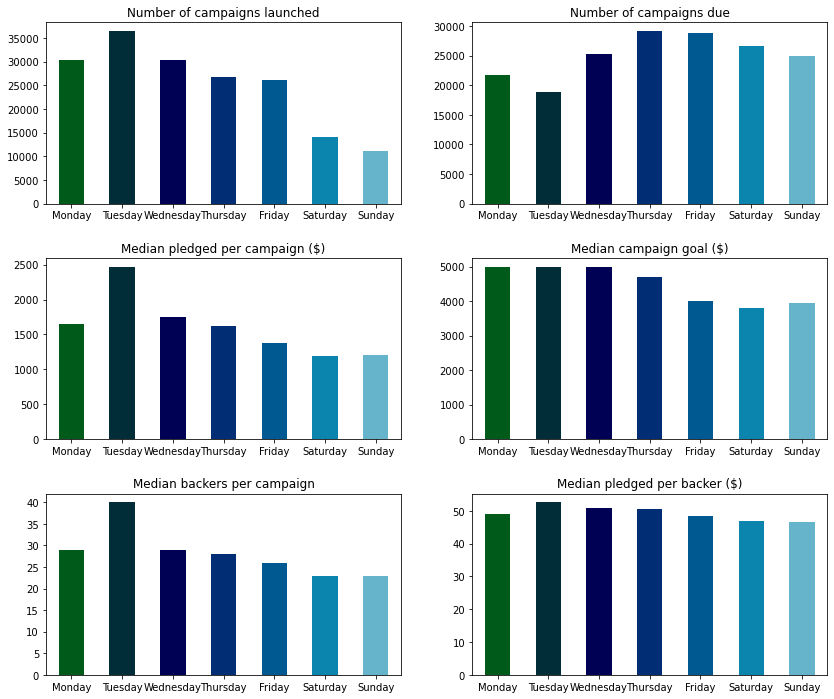

In [46]:
# Creating a dataframe grouped by the day on which they were launched, with columns for failed and successful
day_df = pd.get_dummies(df.set_index('launch_day').state).groupby('launch_day').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.ocean(np.linspace(0.1,0.8,df.launch_day.nunique()))

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df.groupby('launch_day').launch_day.count().reindex(weekdays).plot(kind='bar', ax=ax1, color=color, rot=0)
ax1.set_title('Number of campaigns launched')
ax1.set_xlabel('')

df.groupby('deadline_day').launch_day.count().reindex(weekdays).plot(kind='bar', ax=ax2, color=color, rot=0)
ax2.set_title('Number of campaigns due')
ax2.set_xlabel('')

df.groupby('launch_day').usd_pledged.median().reindex(weekdays).plot(kind='bar', ax=ax3, color=color, rot=0)
ax3.set_title('Median pledged per campaign ($)')
ax3.set_xlabel('')

df.groupby('launch_day').usd_goal.median().reindex(weekdays).plot(kind='bar', ax=ax4, color=color, rot=0)
ax4.set_title('Median campaign goal ($)')
ax4.set_xlabel('')

df.groupby('launch_day').backers_count.median().reindex(weekdays).plot(kind='bar', ax=ax5, color=color, rot=0)
ax5.set_title('Median backers per campaign')
ax5.set_xlabel('')

df.groupby('launch_day').pledge_per_backer.median().reindex(weekdays).plot(kind='bar', ax=ax6, color=color, rot=0)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()